# MNIST

MNIST is a set of 70000 small images of digits handwritten by high school students and employees of US Census Bureau.

SCcikit-Learn provides many helper functions to download popular datasets. MNIST is one of them.

In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original',data_home="./")

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

Datasets loaded by Scikit-Learn generally have a similar dictonary structure including:
+ A *DESCR* key describing the dataset.
- A *data* key containing an array with one row per instance and one column per feature.
+ A *target* key containing an array with labels.

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


This shows that there are 70000 images, and each inmage has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 to 255.

Let's take a peek at onr digit from the dataset.

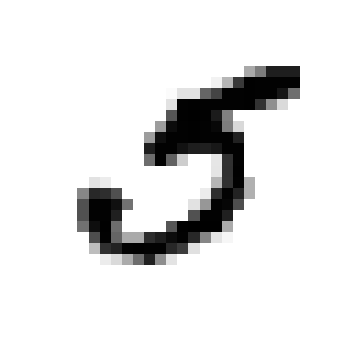

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
print(y[36000])

5.0


It looks like 5, and its label shows that it is 5 indeed.

The MNIST dataset has already been split into a training set (the first 60000 images) and the test set (the last 10000 images)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's shuffle the training set for the following two reasons:
+ This will make all cross-validation folds looks similar. This trys to avoid one fold to be missing some digits.
- Some learning algoithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.

In [8]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

First, we start with the problem with a binary classifier. We will create a '5-detector', which is capable of distinguishing between two classes, 5 and not-5.

These are the target vectors for the classification task:

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's pick a classifier and train it. We will start with a *Stochastic Gradient Decent(SGD, 随机梯度下降法)* classifier, using Scikit-Learn's *SGDClassifier* class.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

Now, we detect it with the image of number 5:

In [11]:
sgd_clf.predict([some_digit])

array([False])

# Performance Measures

Evaluating a classifier is often significantly tricker than evaluating a regressor. There are many performance measures available.

## Measuring Accuracy Using Cross-Validation

Let's use the *cross_val_score()* function to evaluate the *SGDClassifier* model, using K-fold cross-validation, with 3 folds in this case.

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9443, 0.9513, 0.9496])

Let's look at a very dumb classifier which just calssifies every single image in the "not-5" class.

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91065, 0.90985, 0.90845])

This simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demostrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some classes are much more frequent than others)

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *Confusion Matrix*. The general idea is to count the number of times instance of class A are classified as class B. We can use the *cross_val_predict()* function:

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[False False False ... False False False]


The *cross_val_predict()* returns the predictions made on each fold. Now, we can get the confusiong matrix using the *confusion matrix()* function.

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54387,   192],
       [ 2904,  2517]])

The perfect confusion matrix is shown as below:

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Some more concise metric is the *precision* and *recall* (also called *sensitivity* or *true positive rate* or *TPR*)

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [18]:
from sklearn.metrics import precision_score, recall_score
print("Precision_score:", precision_score(y_train_5, y_train_pred))
print("Recall_score:", recall_score(y_train_5, y_train_pred))

Precision_score: 0.929125138427464
Recall_score: 0.4643054786939679


This means that our 5-detector is correct only 58% of its time. Moreover, it detexts 86% of the 5s.

It is often convenient to combine precision and recall into a single metric called the *F1 score*. F1 score is the *harmonic mean(调和平均)* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

To compute the F1 score, simply call the *f1_score()* function:

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.6191881918819188

## Precision/Recall Tradeoff

The Scikit-Learn does not let you set the threshold directly, but it gives you access to the decision scores that it uses to make predictions. Instead of calling the classifier's *predict()* method, you can call its *decision_function()* method, which returns score for each instance, and them make predictions based on those scores using ant threshold you want:

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-14528.71313232]


In [21]:
threshold = -100000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


The *SGDClassifier* uses a threshold equal to 0:

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


So how can you decide which threshold to ues? You need to get the scores of all instances in the training set using the *cross_val_predict()* function again. This time, you need to specify that you want to return decision scores instead of predictions:

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores, you can compute precision and recall for all possible thresholds usoing *precision_recall_curve()* function.

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

We can plot the precision and recall as functions of the threshold value using Matplotlib.

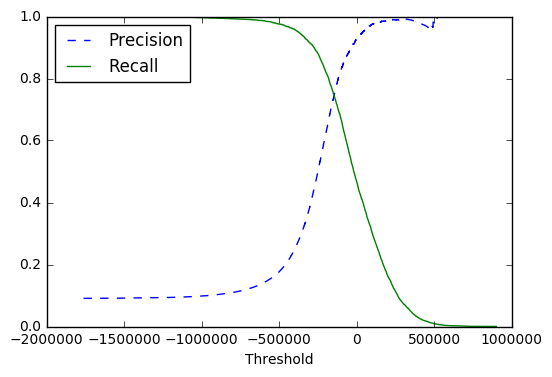

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The precision may sometimes go down when you raise the threshold (althrough in general it will go up). Recall can only go down when the threshold is increased.

Let's suppose that you decide to aim for 90% precision. You look up to the figure and find that you need to use a threshold about 230000. To make predictions, instead of calling the classifier's *predict()* method, you just run the code:

In [30]:
y_train_pred_90 = (y_scores>-40000)

In [31]:
print("Precision_score:",precision_score(y_train_5, y_train_pred_90))
print("Recall_score:", recall_score(y_train_5, y_train_pred_90))

Precision_score: 0.8960880195599022
Recall_score: 0.5408596199963106


## The ROC Curve

The *receiver operating characteristic (ROC)* curve is another common tool used with binary classifiers.

The ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate*. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the *true negative rate*, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus *1-specificity*

To plot the ROC curve, we first need to compute the TPR and FRP for various threshold values, using the *roc_curve()* function:

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then use matplotlib to plot the FPR against the TPR.

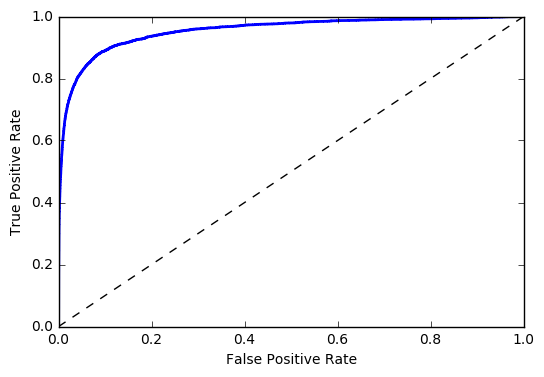

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

There is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible.

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will hava a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9543446174441494

Let's train a *RandomForestClassifier* and compare its ROC curve and ROC AUC score to the *SGDClassifier*. However, the *RandomForestClssifier* class does not have a *decision_function()* method because of the way it works. Instead, it has a *predict_proba()* method. It returns an array containing a row per instance and a column per class, each containing the probality that the given instance belongs to the given class.

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [39]:
print(y_probas_forest)

[[0.9 0.1]
 [1.  0. ]
 [0.9 0.1]
 ...
 [1.  0. ]
 [0.7 0.3]
 [1.  0. ]]


To plot a ROC curve, we need scires, not probabilities. A simple solution is to use the positive class's probability as score:

In [40]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

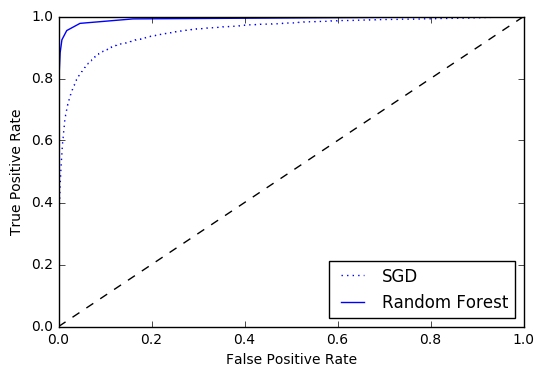

In [44]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The *RandomForestClassifier*'s ROC curve looks much better than the *SGDClassifier*'s. As a result, its ROC AUC score is also significantly better:

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924092166930447

Try measuring the precision and recall scores:

In [48]:
y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Precision_score:", precision_score(y_train_5, y_forest_pred))
print("Recall_score:", recall_score(y_train_5, y_forest_pred))

Precision_score: 0.9826373626373627
Recall_score: 0.8247555801512636


# Multiclass Classification

Whereas binary classifiers distinguish between two classes, *multiclass classifiers* can distinguish between more than two classes.

Some algorithms are capable of handling multiple classes directly. Others are strictly binary classifiers. However, there are various strategies that you can use to perform multicalss classification using multiple binary classifiers:
+ One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit. This is called the the *one-versus-all* (OvA) startegy.
- Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the *one-versus-one* (OvO) strategy.

Some algorithm scale pooly with the size of the training set, so for these algorithms OvO is perferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO)

In [50]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with highest score. You can call *decision_function()* method. It returns 10 scores, one per class:

In [51]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-172907.99482666 -386990.10527257 -380998.19154094 -287182.20046355
  -381293.0989405   -14528.71313232 -564520.82357897 -248302.02164794
  -786519.73491158 -691250.17833168]]


The highest score is indeed the one corresponding to class 5:

In [53]:
max_decision = np.argmax(some_digit_scores)
print(sgd_clf.classes_)
print(sgd_clf.classes_[max_decision])

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
5.0


When a classifier is trained, it stores the list of target classes in its *classes_* attribute, ordered by value.

If you want to force Scikit-Learn to use one-versus-one or one-varsus-all, you can use the *OneVsOneClassifier* or *OneVsRestClassifier* classes. The code creates a multiclass classifier using the OvO strategy, based on*SGDClassifier*

In [56]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5.]
45


Training a *RandomForestClassifier* is just as follows:

In [58]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call *predict_proba()* to get the list of probabilities that the classifier assigned to each instance for each class:

In [59]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0.9, 0. , 0. , 0. , 0. ]])

If we want to evaluate these classifiers, we can use cross-validation as usual.

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87692462, 0.85459273, 0.84297645])

We can update the performance by scaling the inputs using *StandardScaler()* method（它的作用是把数据归一化和标准化，就是让数据方差为1，均值为0）.

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91161768, 0.90954548, 0.90913637])

# Error Analysis

We will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, we can look at the confusion matrix.

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5742    2   26   11   12   41   39   10   37    3]
 [   1 6500   44   27    6   35    8   13   98   10]
 [  57   38 5336  114   82   22   87   58  148   16]
 [  41   44  124 5351    2  234   30   60  140  105]
 [  20   29   33    7 5383    8   52   30   72  208]
 [  77   43   34  186   81 4591  118   28  174   89]
 [  32   23   53    4   47   85 5623    5   46    0]
 [  25   20   74   29   62    9    4 5788   17  237]
 [  48  169   73  162   12  154   56   25 5014  138]
 [  42   35   22   80  160   40    2  212   78 5278]]


It is more convenient to look at an image representation of the confusion matrix.

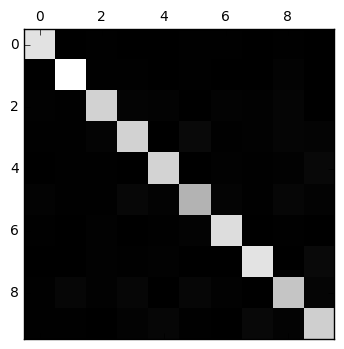

In [63]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

Let's focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rtes instead of number of errors.

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now, we fill the diagonal with zeros to keep only the errors, and plot the result:

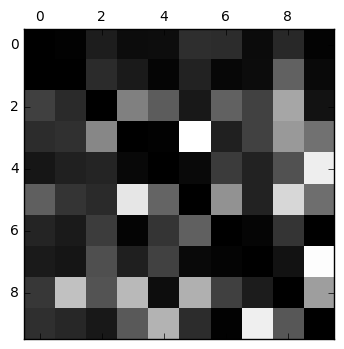

In [69]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Remember that rows represent actual classes, while columns represent prdicted classes. The columns for 8 and 9 are quite bright, which tells you that many images get misclassified as 8s or 9s. Similarly, the rows for class 8 and 9 are also bright, telling you that 8s and 9s are often confused with other digits.

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. From this plot, we can see that we should spend time improving the classification of 8s and 9s, as well as fixing the specific 3/5 confusion.